## Importing libs

In [1]:
import pandas as pd
import os
from tqdm import tqdm 
import numpy as np
import pickle
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from unidecode import unidecode
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Importing data

In [2]:
df_tweets = (
    pd.read_csv('tweets/all_tweets.csv')
    .iloc[:, 1:]
)

In [3]:
df_tweets.shape

(359036, 28)

In [4]:
df_all_trends = pd.read_csv('trends/df_all_trends.csv')

## Dataprep

### Tweets

In [7]:
df_tweets.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21+00:00,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27+00:00,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False


In [8]:
df = (
    df_tweets[['created_at', 'text', 'hashtags', 'id']]
    .copy()
    .set_index('id')
    .dropna(subset=['hashtags'])
)

df['created_at'] = pd.to_datetime(df['created_at'].str[:19])
df.shape

(104861, 3)

In [9]:
df.head(2)

,created_at,text,hashtags
id,,,
1617597872803041280,2023-01-23 18:59:21,"Kararlarındaki temel dayanak, hukukun evrensel...","[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo..."
1617597646339702823,2023-01-23 18:58:27,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu..."


In [10]:
# adding a column with all hashtags as strings
lst_hashtags = []

for i in tqdm(df['hashtags']):
    hashtags = ' '.join([j['tag'] for j in eval(i)])
    lst_hashtags.append(hashtags)

100%|███████████████████████████████████████████████████████████████████████████| 104861/104861 [00:05<00:00, 18387.32it/s]


In [11]:
df['hashtags'] = lst_hashtags

In [12]:
df.head()

,created_at,text,hashtags
id,,,
1617597872803041280,2023-01-23 18:59:21,"Kararlarındaki temel dayanak, hukukun evrensel...",OhalKomisyonuHukuksuzdur
1617597646339702823,2023-01-23 18:58:27,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,OhalKomisyonuHukuksuzdur
1617597571903676417,2023-01-23 18:58:09,RT @Yozgat_KHK: #OhalKomisyonuHukuksuzdur\nÇün...,OhalKomisyonuHukuksuzdur
1617597543000440844,2023-01-23 18:58:02,#OhalKomisyonuHukuksuzdur https://t.co/FHdc5DQ0u0,OhalKomisyonuHukuksuzdur
1617597477963829248,2023-01-23 18:57:46,RT @Malatya_KHK: Öldükten sonra insanlari işe ...,OhalKomisyonuHukuksuzdur


### Trends

Data from the notebook `01_Trends_Scrapping.ipynb`

In [13]:
# parsing datetime

df_all_trends['date'] = pd.to_datetime(df_all_trends['date'], format='%d-%m-%Y')
df_all_trends['datetime'] = pd.to_datetime(df_all_trends['date'].astype(str) + ' ' + df_all_trends['time'])

In [14]:
df_all_trends['trend_topic'] = df_all_trends['trend_topic'].str.replace('#', '')

### Combining

In [15]:
df.head(2)

,created_at,text,hashtags
id,,,
1617597872803041280,2023-01-23 18:59:21,"Kararlarındaki temel dayanak, hukukun evrensel...",OhalKomisyonuHukuksuzdur
1617597646339702823,2023-01-23 18:58:27,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,OhalKomisyonuHukuksuzdur


In [16]:
df_all_trends.head(2)

,time,trend_topic,date,datetime
0,00:10,Zamlar,2022-01-01,2022-01-01 00:10:00
1,00:10,2022NewYear,2022-01-01,2022-01-01 00:10:00


In [37]:
df_all_trends.shape

(188970, 4)

In [40]:
# simplifying trend topics by day instead of time
df_all_trends = df_all_trends[['date', 'trend_topic']].drop_duplicates()

In [41]:
df_all_trends.shape

(32991, 2)

- Identifying trend topics that were present in hashtags of a tweet
- If the absolute date difference between the trend topic and created tweet is less then 1 week (7 days), we assume the tweet was created when a trend topic was happening

In [66]:
for _, i in tqdm(df_all_trends.iterrows(), total=len(df_all_trends)):
    trend_topic = i['trend_topic']
    date = i['date']
    
    data_trend = df[df['hashtags'].str.contains(trend_topic)]
    
    data_trend['trend_topic'] = trend_topic
    data_trend['date'] = date
    data_trend['dt_diff'] = (data_trend['date'] - data_trend['created_at']).dt.days
    
    data_trend = data_trend[data_trend['dt_diff'].abs() <= 7]
    
    if len(data_trend) > 0:
        data_trend.reset_index().to_csv(f'trend_topics/{date.year}-{date.month}-{date.day}_{trend_topic}.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 32991/32991 [1:01:47<00:00,  8.90it/s]


In [67]:
data_trend = pd.DataFrame()
for i in tqdm(os.listdir('trend_topics/')):
    data_trend = pd.concat([
        data_trend,
        pd.read_csv(f'trend_topics/{i}')
    ])

100%|██████████████████████████████████████████████████████████████████████████████████| 4529/4529 [02:10<00:00, 34.80it/s]


In [73]:
# data_trend.to_csv('trend_topics/data_trend.csv', index=False)

In [60]:
data_trend.head()

,id,created_at,text,hashtags,trend_topic,date,dt_diff
0,1480428043957161984,2022-01-10 06:35:25,Hakikatın peşindeki tüm basın emekçileriyle da...,10OcakÇalışanGazetecilerGünü GazetecilikSuçDeg...,10OcakÇalışanGazetecilerGünü,2022-01-10,-1
1,1480453435912720385,2022-01-10 08:16:19,Bugün #10OcakÇalışanGazetecilerGünü Basın üzer...,10OcakÇalışanGazetecilerGünü,10OcakÇalışanGazetecilerGünü,2022-01-10,-1
2,1480522558948745221,2022-01-10 12:50:59,CHP’den basın özgürlüğü raporu: En az 475 kez ...,10OcakÇalışanGazetecilerGünü,10OcakÇalışanGazetecilerGünü,2022-01-10,-1
3,1480450838820761601,2022-01-10 08:06:00,"Türkiye, Sınır Tanımayan Gazeteciler Örgütü’nü...",10OcakÇalışanGazetecilerGünü,10OcakÇalışanGazetecilerGünü,2022-01-10,-1
4,1480450211264839682,2022-01-10 08:03:30,Bugün ağır insan hakları ihlallerinin yaşandığ...,10OcakÇalışanGazetecilerGünü,10OcakÇalışanGazetecilerGünü,2022-01-10,-1


- the majority of the tweets are indead created in less then 1 day when a trend topic was happening

In [72]:
data_trend['dt_diff'].value_counts().sort_index()

-7     1040
-6      785
-5     1294
-4     1512
-3     1958
-2     5030
-1    68490
 0    12394
 1     2103
 2      979
 3      882
 4      571
 5      664
 6     1520
 7      433
Name: dt_diff, dtype: int64

## Modeling

In [75]:
df_tweets.head(2)

,author_id,context_annotations,conversation_id,created_at,edit_history_tweet_ids,id,in_reply_to_user_id,lang,possibly_sensitive,referenced_tweets,reply_settings,text,author,withheld,geo,quote_count,retweet_count,like_count,reply_count,impression_count,media_keys,poll_ids,hashtags,urls,mentions,cashtags,annotations,is_retweet
0,1449804331142811655,NaN,1617597872803041280,2023-01-23 18:59:21+00:00,[1617597872803041280],1617597872803041280,NaN,tr,False,NaN,everyone,"Kararlarındaki temel dayanak, hukukun evrensel...",Goksun_KHK,NaN,NaN,0,2,1,0,82,NaN,NaN,"[{'start': 95, 'end': 120, 'tag': 'OhalKomisyo...",NaN,NaN,NaN,NaN,False
1,1449804331142811655,NaN,1617597646339702823,2023-01-23 18:58:27+00:00,[1617597646339702823],1617597646339702823,NaN,qme,False,NaN,everyone,#OhalKomisyonuHukuksuzdur https://t.co/3aUr5MZWPU,Goksun_KHK,NaN,NaN,0,1,0,0,52,['3_1617597636604723228'],NaN,"[{'start': 0, 'end': 25, 'tag': 'OhalKomisyonu...","[{'start': 26, 'end': 49, 'url': 'https://t.co...",NaN,NaN,NaN,False


In [78]:
df_tweets.shape, data_trend.shape

((359036, 28), (99655, 7))

In [97]:
df_tweets.shape, a.shape

((359036, 28), (72241, 3))

### Feature engineering

- creating the following features for each tweet id:
    - unique hashtags in tweet associated with a trend topic
    - total number of hashtags in tweet associated with a trend topic

In [95]:
data_trend = data_trend.groupby('id', as_index=False).agg(
    unique_hashtags_in_trend=('trend_topic', 'nunique'),
    num_hashtags_in_trend=('trend_topic', 'count'),
)

In [157]:
df = (
    pd.merge(
        df_tweets[['id', 'in_reply_to_user_id', 'quote_count', 'retweet_count', 'like_count', 'text', 'hashtags', 'reply_count', 'is_retweet', 'media_keys', 'mentions']],
        data_trend, on='id', how='left'
    )
    .set_index('id')
)

In [158]:
df['text_length'] = df['text'].apply(lambda x: len(x))
df['has_media'] = np.where(df['media_keys'].isna(), 0, 1)
df['has_hashtags'] = np.where(df['hashtags'].isna(), 0, 1)
df['has_mentions'] = np.where(df['mentions'].isna(), 0, 1)
df['is_retweet'] = df['is_retweet'].astype(int)
df['is_reply'] = np.where(df['in_reply_to_user_id'].isna(), 0, 1)

- tweets that are retweets and that are reply present distinct popularity behavour when it comes to number of likes and retweets
- therefore we created different models for each of the following tweeet types:
    - is only reply tweet
    - is only retweet tweet
    - isn' reply nor retweet tweet
    - there were not tweets that are reply and retweet

In [159]:
pd.crosstab(df['is_retweet'], df['is_reply'])

is_reply,0,1
is_retweet,,
0,126167,50220
1,182649,0


In [160]:
df['trend_topic_uniques'] = df['trend_topic_uniques'].fillna(0).astype('int')
df['num_hashtags_in_trend'] = df['num_hashtags_in_trend'].fillna(0).astype('int')

In [161]:
df['tweet_type'] = np.where(df['is_reply']==1, 'only_reply',
                      np.where(df['is_retweet']==1, 'only_retweet', 'no_reply_and_retweet'))

In [162]:
df['tweet_type'].value_counts()

only_retweet            182649
no_reply_and_retweet    126167
only_reply               50220
Name: tweet_type, dtype: int64

In [163]:
df = df.drop(columns=['text','media_keys', 'hashtags' ,'mentions', 'in_reply_to_user_id', 'is_reply', 'is_retweet'])

- below we can see that each tweet type present different count of retweets, likes and replies (this later we didn't use to measure popularity)

In [166]:
df.groupby('tweet_type')[['retweet_count', 'like_count', 'reply_count']].agg(['mean', 'median', 'std', 'count'])

retweet_count                              like_count  \
                              mean median          std   count        mean   
tweet_type                                                                   
no_reply_and_retweet     39.124058    4.0   175.975492  126167  172.967464   
only_reply                4.306790    0.0    32.765494   50220   22.721983   
only_retweet            248.565122   23.0  2434.060377  182649    0.000077   

                                                 reply_count         \
                     median          std   count        mean median   
tweet_type                                                            
no_reply_and_retweet   11.0  1144.099175  126167    6.996053    0.0   
only_reply              2.0   268.186087   50220    0.939805    0.0   
only_retweet            0.0     0.032758  182649    0.000005    0.0   

                                         
                            std   count  
tweet_type                               
no_reply_and_retweet  82.753656  126167  
only_reply             8.677785   50220  
only_retweet           0.002340  182649

### Applying logistic regression

In [197]:
def prepare_dataset(data, target, tweet_type, features=['trend_topic_uniques', 'num_hashtags_in_trend', 'text_length','has_media', 'has_hashtags', 'has_mentions']):
    data = data.query('tweet_type == @tweet_type')
    
    x = data[features]
    y = np.where(data[target] > data[target].median(), 1, 0)
    
    return x, y

In [198]:
x, y = prepare_dataset(df, 'like_count', 'no_reply_and_retweet')

In [233]:
def train_test_lr(x, y, clf=LogisticRegression()):
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    
    print(classification_report(y_test, y_pred))
    
    plt.axvline(x=1, color='red')
    pd.Series(np.exp(lr.coef_[0]), index=lr.feature_names_in_).sort_values().plot.barh()
    plt.show()

=========> Modeling for tweet types:  no_reply_and_retweet
Selected target:  like_count
              precision    recall  f1-score   support

           0       0.62      0.65      0.63     15714
           1       0.63      0.60      0.61     15828

    accuracy                           0.62     31542
   macro avg       0.62      0.62      0.62     31542
weighted avg       0.62      0.62      0.62     31542



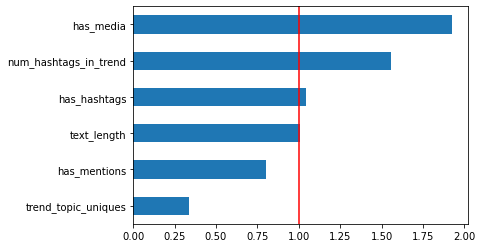


Selected target:  retweet_count
              precision    recall  f1-score   support

           0       0.61      0.70      0.65     16670
           1       0.60      0.51      0.55     14872

    accuracy                           0.61     31542
   macro avg       0.60      0.60      0.60     31542
weighted avg       0.61      0.61      0.60     31542



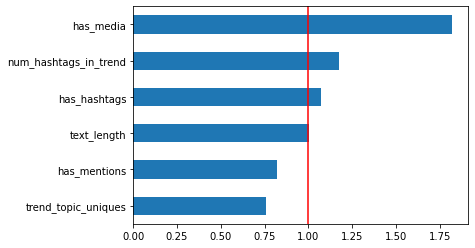


=========> Modeling for tweet types:  only_retweet
Selected target:  like_count
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     45663

    accuracy                           1.00     45663
   macro avg       1.00      1.00      1.00     45663
weighted avg       1.00      1.00      1.00     45663



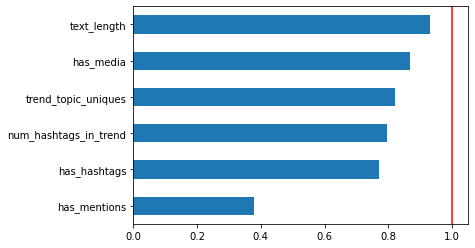


Selected target:  retweet_count
              precision    recall  f1-score   support

           0       0.62      0.45      0.52     22883
           1       0.57      0.72      0.63     22780

    accuracy                           0.58     45663
   macro avg       0.59      0.58      0.58     45663
weighted avg       0.59      0.58      0.58     45663



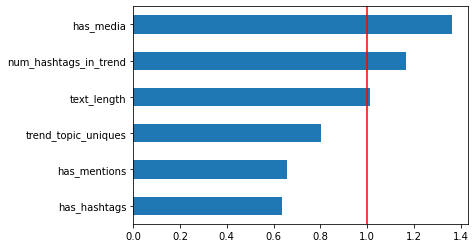


=========> Modeling for tweet types:  only_reply
Selected target:  like_count
              precision    recall  f1-score   support

           0       0.68      0.88      0.77      7640
           1       0.66      0.37      0.48      4915

    accuracy                           0.68     12555
   macro avg       0.67      0.62      0.62     12555
weighted avg       0.68      0.68      0.65     12555



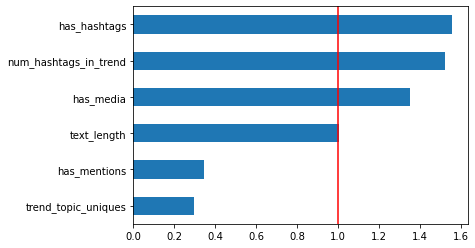


Selected target:  retweet_count
              precision    recall  f1-score   support

           0       0.70      0.84      0.77      7645
           1       0.64      0.44      0.53      4910

    accuracy                           0.69     12555
   macro avg       0.67      0.64      0.65     12555
weighted avg       0.68      0.69      0.67     12555



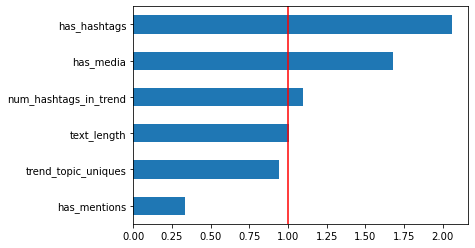

In [239]:
for i in df['tweet_type'].unique():
    print('=========> Modeling for tweet types: ', i)
    for j in ['like_count', 'retweet_count']:        
        print('Selected target: ', j)
        
        x, y = prepare_dataset(df, j, i)
        train_test_lr(x, y)
        print('='*60)
        print('='*60, '\n')

Some main conclusions are:
- no_reply_and_retweet
    - has_media and number of hashtags in topic trend are direct assotiated with the number of likes and retweets